# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version. 

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have. 


In [1]:

import numpy as np
from model import Environment, Agent
from display import plot_regret


from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Action generators 

In [2]:
def randomActionsGenerator(K, d):
    """
    K: int -- number of action vectors to be generated
    d: int -- dimension of the action space
    returns: an array of K vectors uniformly sampled on the unit sphere in R^d
    """

    vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=K)
    norms = np.linalg.norm(vecs, axis=1)
    return vecs / norms[:, np.newaxis]

In [3]:
a = randomActionsGenerator(100, 2)

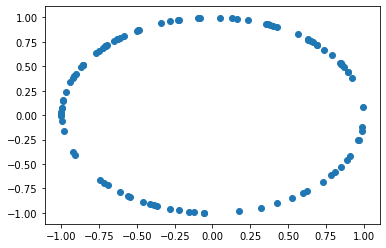

In [4]:
plt.scatter(a[:, 0], a[:, 1])
plt.show()

# Environment Class

In [5]:
class LinearBandit(Environment):
    def __init__(self, theta, K, model='gaussian', var=1.):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.model = model
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        
    def get_action_set(self):
        self.current_action_set = randomActionsGenerator(self.K, self.d)
        return self.current_action_set
        
    def get_reward(self, action):
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        if self.model == 'gaussian':
            return np.random.normal(mean, scale=self.var)
        else:#add bernoulli model option
            raise NotImplementedError('only Gaussian rewards are implemented so far')
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)

# Linear Bandit Agents


## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

* Baselines: First implement a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Then, implement an LinEpsilonGreedy agent as seen in the previous Lab. Do you think these agents can have a sublinear regret ? Open question: Are they good baselines ?


* Implement LinUCB as studied in class: as for LinUCB, you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards. 

* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.


* It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ? 
Implement this little modification and compare the results for several values of $\alpha$ (see further down for experiments scripts).



In [6]:
class LinUniform(Agent):
    def __init__(self):
        pass

    def get_action(self, arms):
        K, _ = arms.shape
        return arms[np.random.choice(K)]

    def receive_reward(self, chosen_arm, reward):
        pass

    def reset(self):
        pass

    #@staticmethod
    def name(self):
        return 'Unif'  

In [13]:
class LinEpsilonGreedy(Agent):
    def __init__(self, T, d, epsilon):
        " instantiate the agent using only the available information from the environment (i.e. not the means)"
        self.epsilon = epsilon
        self.T = T
        self.t = 0
        self.d = d

        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])
        self.t = 0

    def get_action(self, arms):
        """
        This function implements LinEpsilonGreedy
        Input:
        -------
        arms: list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm: pulled arm
        """
        # compute the UCB of each of the arm in arms, here arms are vectors:
        K, _ = arms.shape

        # implement epsilon-greedy:
        chosen_arm_index = 0
        if np.random.random() < self.epsilon:
            chosen_arm_index = np.random.randint(0, high=K)
        else:
            UCBs = np.zeros(K)

            for i in range(K):
                cur_arm = np.expand_dims(arms[i], axis=0)
                UCBs[i] = self.hat_theta.T @ cur_arm.T
            chosen_arm_index = np.argmax(UCBs)

        self.t += 1

        chosen_arm = arms[chosen_arm_index]

        return chosen_arm
        
    def receive_reward(self, chosen_arm, reward):
        # Computing RLS:
        self.V += chosen_arm.T @ chosen_arm # + self.lambda_reg * np.eye(self.d)
        self.b_n += reward * chosen_arm
        self.hat_theta = pinv(self.V) @ self.b_n.T
        
    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted:
        self.t = 0
        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])
        
    def name(self):
        return "LinEpsGreedy; $\epsilon$ = {:.1f}".format(self.epsilon)

In [8]:
from numpy.linalg import pinv


class LinUCB(Agent):
    def __init__(self, T, d, delta, lambda_reg, alpha=None):
        """
        Input:
        -------
        T: number of iterations (time intervals)
        d: arm's dimension
        delta: 
        lambda_reg: 
        alpha: exploration bonus coefficient
        TODO: describe inputs 
        TODO: add an input alpha to optionally scale the exploration bonus in the get_action function
        """
        self.T = T
        self.t = 0
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        ### TODO
        self.alpha = alpha

        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])

        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted:
        self.t = 0
        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])

    def get_action(self, arms):
        """
        This function implements LinUCB
        Input:
        -------
        arms: list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm: pulled arm
        """
        # compute the UCB of each of the arm in arms, here arms are vectors:
        K, _ = arms.shape
        UCBs = np.zeros(K)

        ### TODO
        inverse_V = pinv(self.V)
        beta_t = np.sqrt(self.lambda_reg) + np.sqrt(2 * np.log(1 / self.delta) \
                    + self.d * np.log((self.d * self.lambda_reg + self.t) / (self.lambda_reg * self.d)))
        if self.alpha:
            beta_t *= self.alpha

        for i in range(K):
            cur_arm = np.expand_dims(arms[i], axis=0)
            UCBs[i] = self.hat_theta.T @ cur_arm.T + beta_t * np.sqrt(cur_arm @ inverse_V @ cur_arm.T)
        chosen_arm = arms[np.argmax(UCBs)]

        self.t += 1

        return chosen_arm

    def receive_reward(self, chosen_arm, reward):
        # Computing RLS:
        self.V += chosen_arm.T @ chosen_arm + self.lambda_reg * np.eye(self.d)
        self.b_n += reward * chosen_arm
        self.hat_theta = pinv(self.V) @ self.b_n.T

    def name(self):
        name = "LinUCB; $\lambda$ = {:.1f}".format(self.lambda_reg)
        if self.alpha is not None:
            name += "; $\\alpha$ = " + str(self.alpha)

        return name

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 
* Implement a LinTS (Linear Thompson Sampling) agent and run it against LinUCB and LinUCB with some $alpha$ scaling parameter (see further down).

In [263]:
class LinTS(Agent):
    def __init__(self, T, d, delta, lambda_reg, alpha=None):
        """
        TODO: describe inputs
        """
        self.T = T
        self.t = 0
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg

        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])

        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        ### TODO

        self.V = np.zeros([self.d, self.d])
        self.b_n = np.zeros([1, self.d])
        self.hat_theta = np.zeros([self.d, 1])

    def get_action(self, arms):
        """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        # compute the UCB of each of the arm in arms, here arms are vectors
        #     ucbs = np.array(K)

        #     for i in range(K):
        #         ucbs[i] = 1# use hat_theta and beta and the covariance matrix. beta_n is the upper bound given at the very end of the class
            
        # K, _ = arms.shape
        # self.UCBs = np.zeros(K)

        # inverse_V = pinv(self.V)

        # beta_t = np.sqrt(self.lambda_reg) + np.sqrt(2 * np.log(1 / self.delta) \
        #             + self.d * np.log((self.d * self.lambda_reg + self.t) / (self.lambda_reg * self.d)))

        # ### TODO
        # # UCBs = self.hat_theta.T @ arms.T + beta_t * np.sqrt(arms @ inverse_V @ arms.T)

        # for i in range(K):
        #     print(arms[i])
        #     UCBs[i] = self.hat_theta.T @ arms[i].T + beta_t * np.sqrt(arms[i] @ inverse_V @ arms[i].T)

        # # max_UCBs = np.max(np.nan_to_num(UCBs), axis=1)

        # print(UCBs)
        # # print(max_UCBs)

        # chosen_arm = arms[np.argmax(np.nan_to_num(UCBs))]

        # self.t += 1

        return chosen_arm


    def receive_reward(self, chosen_arm, reward):
        # Computing RLS:
        self.V += chosen_arm.T @ chosen_arm + self.lambda_reg * np.eye(self.d)

        self.b_n += reward * chosen_arm

        self.hat_theta = pinv(self.V) @ self.b_n.T

        ### TODO

        # pass


    def name(self):
        name = "LinUCB; $\lambda$ = {:.1f}".format(self.lambda_reg)
        if self.alpha:
            name += "alpha = " + str(self.alpha)

        return name

# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [9]:
def play(environment, agent, Nmc, T):
    data = np.zeros((Nmc, T))
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action, reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n, t] = best_reward - reward
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent, Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

# Example: LinUCB versus LinUniform

In [64]:
# import time

d = 2  # dimension
K = 8  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 100  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10

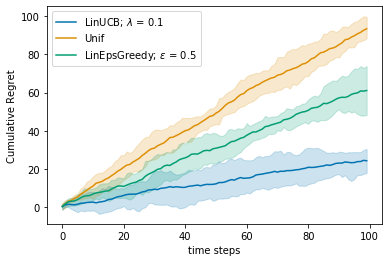

In [65]:

basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=.1)
agent2 = LinUniform()
agent3 = LinEpsilonGreedy(T, d, epsilon=.5)

all_data = experiment(basicGaussianBandit, [agent1, agent2, agent3], Nmc=N, T=T)

plot_regret(all_data)

### You should get a straight diagonal line for Unif and a nice, almost flat curve for LinUCB.
(figure generated with the right implementation)

## Discussion: 
LinUCB takes as input a parameter lambda_reg that controls the regularisation in the least squares estimation. Choosing it is not easy and to the best of my knowledge there is no clear rule... but maybe we could see experimentally if it impacts the results. Run a few LinUCB with different lambda_reg values and plot the results. Beware ! You will have to modify the function "name()" of LinUCB to include the chosen value, otherwise the plotting function will overwrite each curve (this holds for the next experiments as well).

# LinUCB with $\alpha$ scaling



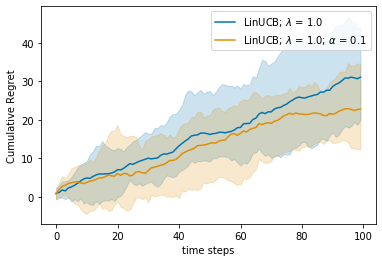

In [267]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinUCB(T, d, delta, lambda_reg=1., alpha=0.1)
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=10, T=100)

plot_regret(all_data)

## Discussion : please comment on your results briefly. Do they validate your hypotheses or not ? Why ?

# LinTS versus LinUCB


In [ ]:
basicGaussianBandit = LinearBandit(theta, K)
agent1 = LinUCB(T, d, delta, lambda_reg=1.)
agent2 = LinTS(T, d, delta, lambda_reg=1.)
#....TODO

all_data = experiment(basicGaussianBandit, [agent1, agent2], Nmc=10, T=100)

plot_regret(all_data)

## Discussion : please comment on your results briefly. Do they validate your hypotheses or not ? Why ?